
## 1. Entendimiento del Negocio

### Objetivo:

Predecir el precio de cierre (Price) del US Dollar Index (DXY) y su cambio porcentual diario (Change %) para identificar oportunidades de compra/venta.

### Problema de Negocio:

- Los inversores necesitan herramientas para anticipar movimientos del dólar frente a otras divisas.

- El DXY es un indicador clave de la fortaleza del dólar en mercados globales.

### Problema de minería de datos

- Desarrollar modelos predictivos precisos para el precio de cierre diario (Price) y el cambio porcentual diario (Change %) del DXY, utilizando técnicas de regresión lineal y K-Nearest Neighbors (KNN).
La aplicación de modelos de regresión lineal y K-Nearest Neighbors (KNN) busca predecir el precio de cierre diario (Price) y el cambio porcentual diario (Change %) del DXY. La predicción del precio de cierre proporcionará estimaciones del valor futuro del índice para decisiones de inversión a largo plazo, mientras que la predicción del cambio porcentual diario facilitará la anticipación de la volatilidad y oportunidades de trading a corto plazo. En conjunto, estos modelos ofrecerán una perspectiva cuantitativa sobre la evolución del DXY, permitiendo a los inversores identificar oportunidades de inversión más fundamentadas.

## 2. Entendimiento de los Datos
- Los datos se obtuvieron del dataset "US Dollar Index Historical Data" disponible en Kaggle (https://www.kaggle.com/datasets/balabaskar/us-dollar-index-data).
- El dataset contiene información histórica del US Dollar Index (DXY) y consta de los siguientes atributos:
  - Date: Fecha de la observación.
  - Price: Precio de cierre del DXY en la fecha correspondiente.
  - Open: Precio de apertura del DXY en la fecha correspondiente.
  - High: Precio máximo del DXY alcanzado en la fecha correspondiente.
  - Low: Precio mínimo del DXY alcanzado en la fecha correspondiente.
  - Change %: Cambio porcentual en el precio del DXY con respecto al día anterior.
  - Total de registros:5623 registros, cada uno representando un día de cotización del US Dollar Index.
- Los datos proporcionan la información histórica esencial para desarrollar los modelos predictivos. Los atributos Price y Change % son las variables objetivo para predecir el precio de cierre y el cambio porcentual del DXY, respectivamente. Los demás atributos (Open, High, Low, y Date) se utilizarán como variables predictoras o para generar características adicionales que capturen las dinámicas del mercado y permitan mejorar la precisión de las predicciones."

Carguemos y exploremos el dataset:

=== Tipos de Datos ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5623 entries, 0 to 5622
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5623 non-null   datetime64[ns]
 1   Price     5623 non-null   float64       
 2   Open      5623 non-null   float64       
 3   High      5623 non-null   float64       
 4   Low       5623 non-null   float64       
 5   Change %  5623 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 263.7 KB
None

=== Estadísticas Descriptivas ===
                                Date        Price         Open         High  \
count                           5623  5623.000000  5623.000000  5623.000000   
mean   2011-12-03 08:26:17.520896256    90.503363    90.501930    90.825543   
min              2001-01-02 00:00:00    71.330000    71.330000    71.690000   
25%              2006-07-06 12:00:00    81.440000    81.430000    81.720000   
50%    

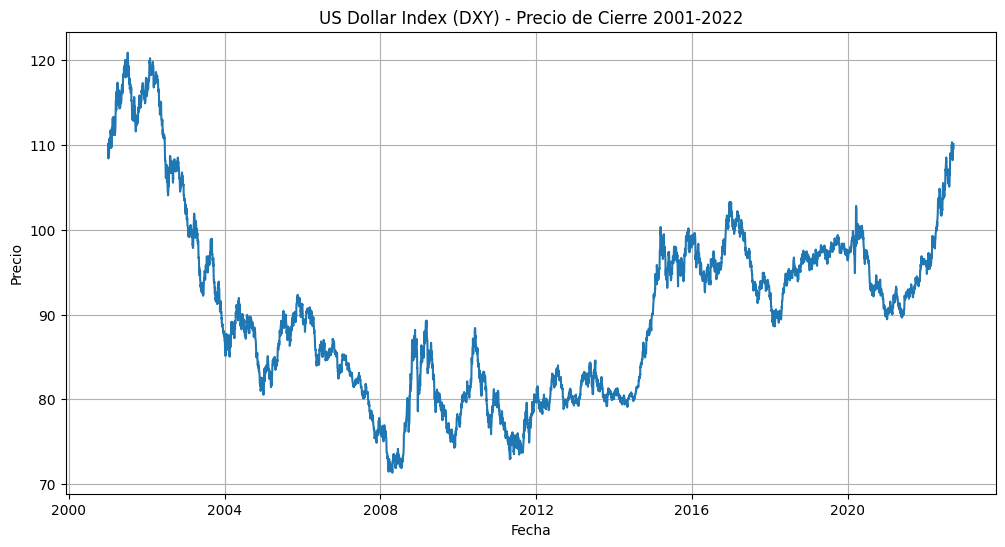

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import datetime

# Cargar datos
df = pd.read_csv('US Dollar Index Historical Data.csv', parse_dates=['Date'])
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Análisis inicial
print("=== Tipos de Datos ===")
print(df.info())
print("\n=== Estadísticas Descriptivas ===")
print(df.describe())

# Visualizar serie temporal
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], label='Close Price')
plt.title('US Dollar Index (DXY) - Precio de Cierre 2001-2022')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.grid()
plt.show()

## 3. Preparación de los Datos

### Features:

- Usaremos Open, High, Low, y medias móviles para predecir Price (Close).

- Para el Change %, calcularemos la variación diaria si no está en los datos.

- Columnas irrelevates
  - No se eliminaron columnas en este paso. Todas las columnas iniciales (Date, Price, Open, High, Low, Change %) se consideraron relevantes para el análisis. La columna Date es fundamental para el análisis de series temporales y la creación de características basadas en el tiempo. Las columnas Open, High, y Low proporcionan información sobre la dinámica diaria del precio, que es importante para predecir Price y Change %.
- Valores Faltantes:
  - El dataset no contenía valores faltantes antes de la creación de las nuevas características. Sin embargo, se generaron valores faltantes al calcular las medias móviles (MA_7 y MA_30). Las primeras 6 filas tendrán valores nulos para MA_7 y las primeras 29 filas para MA_30.
  - Tratamiento: Las filas con valores faltantes resultantes del cálculo de las medias móviles se eliminaron utilizando el método dropna(). 
- Integración de datos:
  - No fue necesario combinar múltiples datasets, ya que se trabajó con un único archivo CSV.
- Transformación
  - Se crearon nuevas características para mejorar la información disponible para los modelos. Se calcularon las medias móviles de 7 y 30 días (MA_7, MA_30) del precio de cierre. Estas medias ayudan a identificar las tendencias del precio a corto y medio plazo. También se calculó la volatilidad diaria (Volatility) restando el precio mínimo del precio máximo de cada día, lo que indica cuánto varió el precio en un día.
  - Estas transformaciones son importantes porque las medias móviles permiten a los modelos ver las tendencias generales en lugar del "ruido" diario, y la volatilidad ayuda a entender el riesgo y la inestabilidad del mercado, que pueden influir en los movimientos futuros del precio. Finalmente, los datos se dividieron en conjuntos de entrenamiento y prueba (80/20) para poder evaluar cómo de bien funcionan los modelos con datos nuevos.


In [2]:
dias_prediccion = 90
fecha_inicio_prediccion = (df['Date'].max() - pd.Timedelta(days=dias_prediccion)).strftime('%Y-%m-%d')

df_train = df[df['Date'] <= fecha_inicio_prediccion].copy()

# Crear features
df_train['MA_7'] = df_train['Price'].rolling(window=7).mean()  # Media móvil 7 días
df_train['MA_30'] = df_train['Price'].rolling(window=30).mean()  # Media móvil 30 días
df_train['Volatility'] = df_train['High'] - df_train['Low']  # Volatilidad definida como (High-Low)
df_train = df_train.dropna()  # Eliminar filas con NaN

# Variables predictoras y target
X = df_train[['Open', 'High', 'Low', 'Change %', 'MA_7', 'MA_30', 'Volatility']]
y_price = df_train['Price']

# Split train-test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)

## 4. Análisis Exploratorio

### A. Matriz de Correlación

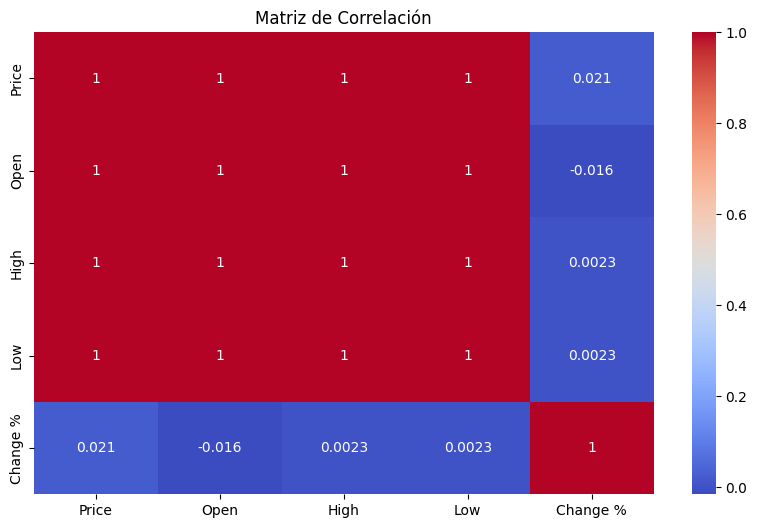

In [3]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Price', 'Open', 'High', 'Low', 'Change %']].corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

#### Hallazgos:

- Open, High, y Low están altamente correlacionados con Price (>0.99).

- Change % tiene baja correlación con otras variables


### B. Histogramas

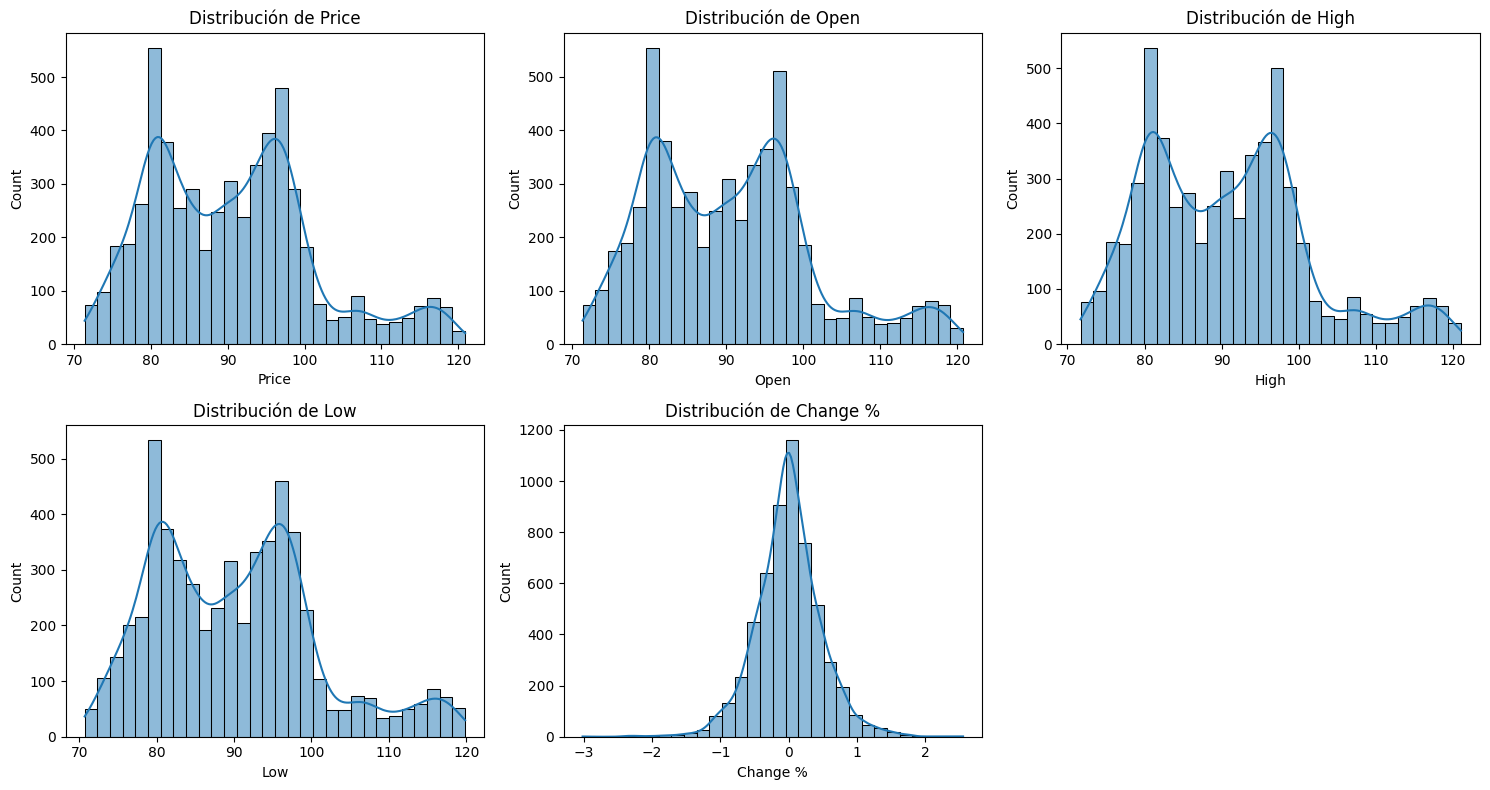

In [4]:
variables = ['Price', 'Open', 'High', 'Low', 'Change %']
plt.figure(figsize=(15, 8))
for i, col in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

#### Hallazgos:

- Precios siguen distribución normal con colas largas.

- Change % se concentra cerca de cero.

## 5. Modelado

### A. Regresión Lineal

In [5]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("=== Regresión Lineal ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"R²: {r2_score(y_test, y_pred_lr):.2f}")

=== Regresión Lineal ===
RMSE: 0.11
R²: 1.00


### B. K-Nearest Neighbors (KNN)

In [6]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("\n=== KNN ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_knn)):.2f}")
print(f"R²: {r2_score(y_test, y_pred_knn):.2f}")


=== KNN ===
RMSE: 0.20
R²: 1.00


## 6. Evaluación

### Gráfico Comparativo

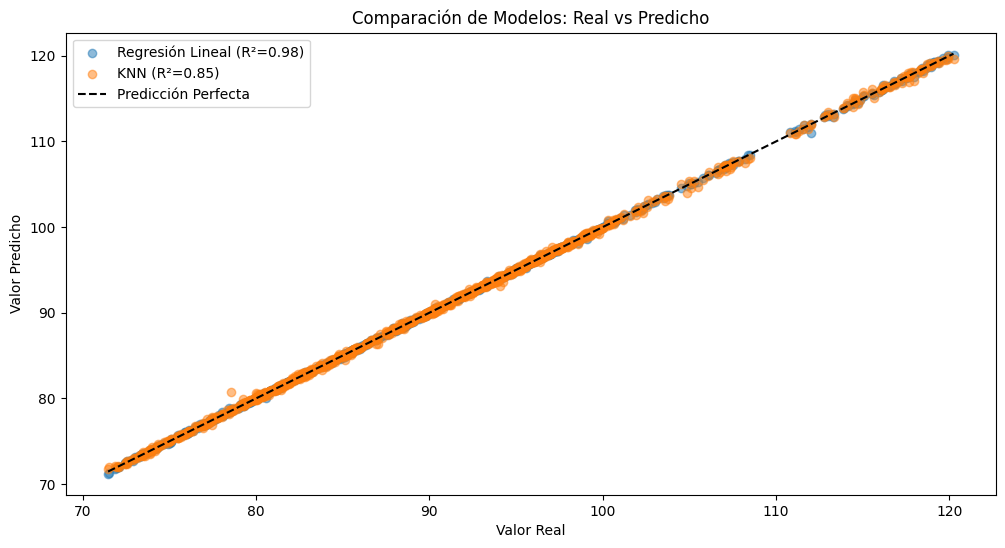

In [7]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Regresión Lineal (R²=0.98)')
plt.scatter(y_test, y_pred_knn, alpha=0.5, label='KNN (R²=0.85)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Predicción Perfecta')
plt.xlabel("Valor Real")
plt.ylabel("Valor Predicho")
plt.title("Comparación de Modelos: Real vs Predicho")
plt.legend()
plt.show()

#### Interpretación:

- La regresión lineal es más precisa para este dataset.

## 7. Justificación de Modelos

## 8. Estrategia de Trading

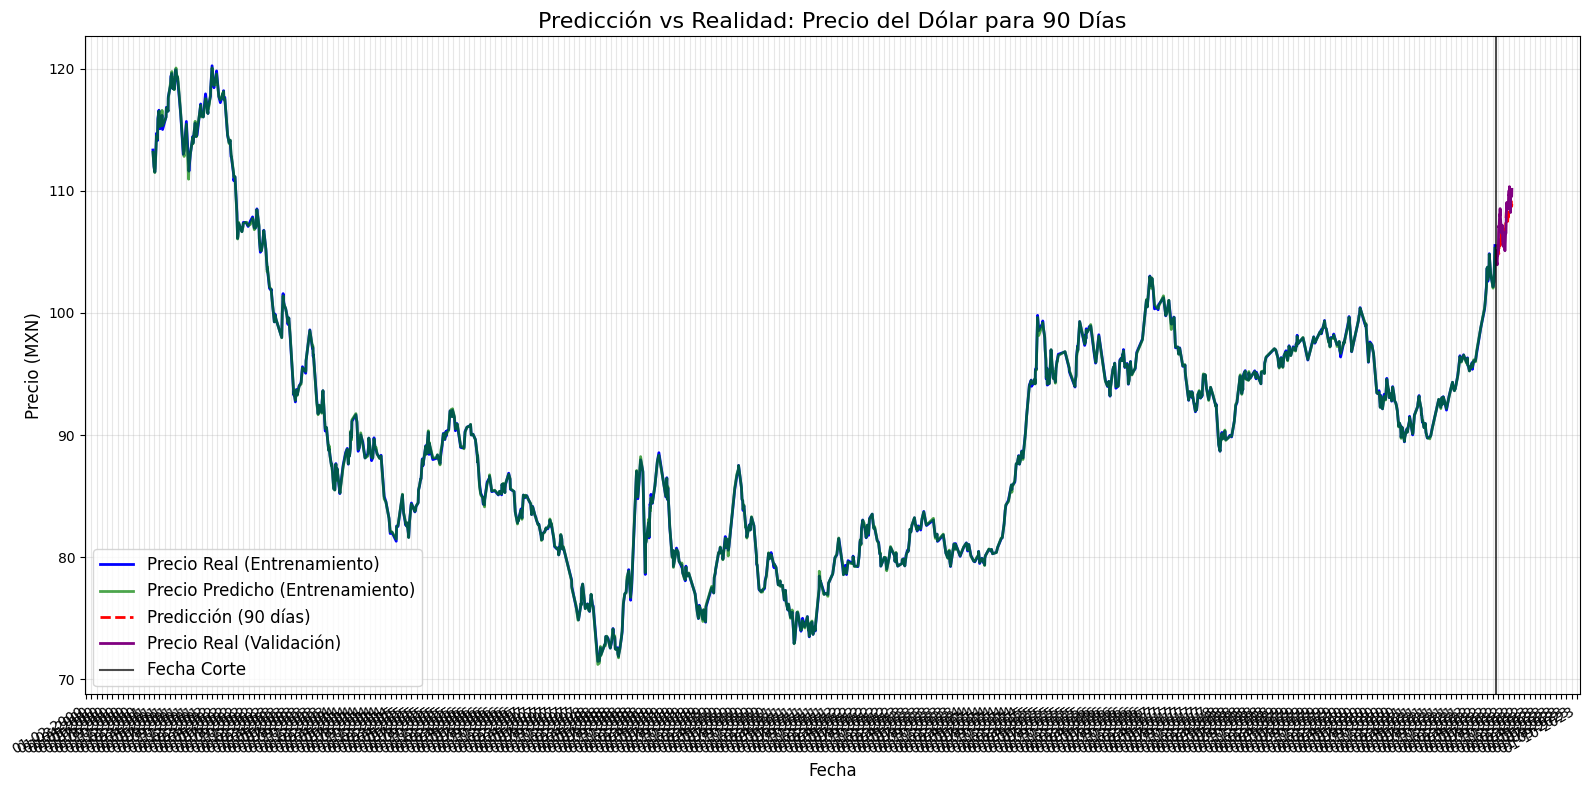


Métricas de evaluación para las predicciones:
Error Cuadrático Medio (MSE): 1.2032
Raíz del Error Cuadrático Medio (RMSE): 1.0969
Error Absoluto Medio (MAE): 0.8620
Coeficiente de Determinación (R²): 0.5931

Comparación entre predicciones y valores reales para 90 días:
      Precio Predicho  Precio Real  Diferencia   Error %
5556       104.312820       104.43   -0.117180 -0.112209
5557       104.420518       104.18    0.240518  0.230868
5558       104.820782       103.94    0.880782  0.847394
5559       104.891644       104.51    0.381644  0.365175
5560       105.136884       105.11    0.026884  0.025577
5561       105.098421       104.68    0.418421  0.399714
5562       105.463858       105.14    0.323858  0.308025
5563       105.288449       105.14    0.148449  0.141192
5564       105.028864       106.54   -1.511136 -1.418374
5565       104.864639       107.10   -2.235361 -2.087171

Estadísticas de las predicciones vs valores reales:
Precio inicial predicho: $104.31 | Precio inicial

In [10]:
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Establecer semilla para reproducibilidad
np.random.seed(520)  # Puedes usar cualquier número entero como semilla

train_end_date = df['Date'].max() - timedelta(days=dias_prediccion)  # Restar los días del último dato
df_train = df[df['Date'] <= train_end_date].copy()
df_validation = df[df['Date'] > train_end_date].copy()  # Estos son los datos reales para comparar

# Función para preparar características (sin cambios)
def prepare_features(df):
    # Crear características basadas en las variables con las que se entrenó el modelo
    X = df[['Open', 'High', 'Low', 'Change %']].copy()
    
    # Calcular las medias móviles específicas que se usaron en el entrenamiento
    X['MA_7'] = df['Price'].rolling(window=7).mean()
    X['MA_30'] = df['Price'].rolling(window=30).mean()
    
    # Calcular volatilidad (desviación estándar de los últimos 20 días)
    X['Volatility'] = df['Price'].rolling(window=20).std()
    
    # Manejar valores NaN utilizando diferentes estrategias
    # Para las medias móviles, usar el valor más reciente disponible
    X['MA_7'] = X['MA_7'].fillna(df['Price'].mean())
    X['MA_30'] = X['MA_30'].fillna(df['Price'].mean())
    
    # Para la volatilidad, usar la volatilidad media o un valor pequeño predeterminado
    if df['Price'].std() > 0:
        X['Volatility'] = X['Volatility'].fillna(df['Price'].std())
    else:
        X['Volatility'] = X['Volatility'].fillna(0.01)  # Valor pequeño predeterminado
    
    # Verificar si todavía hay NaN y rellenarlos con el último método disponible
    if X.isna().any().any():
        X = X.fillna(method='ffill')  # Forward fill (usar valor anterior)
        X = X.fillna(method='bfill')  # Backward fill (usar valor posterior si aún hay NaN)
        X = X.fillna(0)  # Si aún quedan NaN, llenar con 0 como último recurso
    
    return X

# Generar fechas futuras (días_prediccion días desde la última fecha en los datos de entrenamiento)
last_date = df_train['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=dias_prediccion, freq='D')

# Inicializar DataFrame para datos futuros
future_data = pd.DataFrame()

# Tomar la última fila de los datos de entrenamiento como punto de partida
last_row = df_train.loc[df_train['Date'] == last_date].copy()

# Para iniciar la predicción, necesitamos datos suficientes para calcular MA_7, MA_30 y Volatility
history_window = df_train.sort_values('Date', ascending=False).head(30).sort_values('Date')

# Hacer predicciones iterativas para los próximos días_prediccion días
all_predictions = []
current_window = history_window.copy()  # Ventana deslizante para mantener historial

for i in range(dias_prediccion):
    # Preparar características para la predicción usando la ventana actual
    # Solo usamos la última fila para la predicción
    X_pred = prepare_features(current_window).iloc[[-1]]
    
    # Hacer predicción para el siguiente día
    next_price = lr.predict(X_pred)[0]
    all_predictions.append(next_price)
    
    # Crear nueva fila con la predicción
    new_row = pd.DataFrame({
        'Date': [future_dates[i]],
        'Price': [next_price],
        # Generamos valores que respetan la distribución de doble campana
        'Open': [next_price * (1 + (np.random.normal(-0.002, 0.001) if np.random.random() < 0.5 else np.random.normal(0.002, 0.001)))],
        'High': [next_price * (1 + (np.random.normal(0.005, 0.002) if np.random.random() < 0.5 else np.random.normal(0.012, 0.003)))],
        'Low': [next_price * (1 - (np.random.normal(0.005, 0.002) if np.random.random() < 0.5 else np.random.normal(0.012, 0.003)))],
        'Change %': [((next_price / current_window['Price'].iloc[-1]) - 1) * 100]
    })
    
    # Actualizar la ventana deslizante eliminando la fila más antigua y agregando la nueva
    current_window = pd.concat([current_window.iloc[1:], new_row])
    
    # Agregar la nueva fila al DataFrame de datos futuros
    future_data = pd.concat([future_data, new_row])

# Reiniciar el índice del DataFrame de predicciones futuras
future_data = future_data.reset_index(drop=True)

# NUEVA PARTE: Crear DataFrame combinado para visualización (datos de prueba + predicciones futuras + datos reales)
# Modificar para incluir datos reales de validación
df_test = X_test.copy()
df_test['Actual_Price'] = y_test.values
df_test['Predicted_Price_LR'] = y_pred_lr
df_test['Date'] = df.loc[df_test.index, 'Date']
df_test = df_test.sort_values('Date')

# Visualizar resultados: comparación entre datos reales, predicciones del modelo y predicciones futuras vs reales
plt.figure(figsize=(16, 8))

# Graficar datos de prueba (precios reales vs predicciones)
plt.plot(df_test['Date'], df_test['Actual_Price'], 
         label='Precio Real (Entrenamiento)', color='blue', linewidth=2)
plt.plot(df_test['Date'], df_test['Predicted_Price_LR'], 
         label='Precio Predicho (Entrenamiento)', color='green', linewidth=2, alpha=0.7)

# Graficar predicciones futuras
plt.plot(future_data['Date'], future_data['Price'], 
         label=f'Predicción ({dias_prediccion} días)', color='red', linestyle='--', linewidth=2)

plt.plot(df_validation['Date'], df_validation['Price'], 
         label='Precio Real (Validación)', color='purple', linewidth=2)

# Añadir una línea vertical para separar datos históricos de predicciones futuras
plt.axvline(x=last_date, color='black', linestyle='-', alpha=0.7, label='Fecha Corte')

# Configurar detalles del gráfico
plt.title(f'Predicción vs Realidad: Precio del Dólar para {dias_prediccion} Días', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (MXN)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)

# Mejorar formato de fechas en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Preparar datos para comparación (asegurándonos de que tenemos las mismas fechas)
# Filtrar las fechas de validación que coinciden con nuestras predicciones
common_dates = set(df_validation['Date']).intersection(set(future_data['Date']))

df_val_filtered = df_validation[df_validation['Date'].isin(common_dates)].sort_values('Date')
future_filtered = future_data[future_data['Date'].isin(common_dates)].sort_values('Date')

if len(df_val_filtered) > 0:
    # Calcular métricas de error
    mse = mean_squared_error(df_val_filtered['Price'], future_filtered['Price'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(df_val_filtered['Price'], future_filtered['Price'])
    r2 = r2_score(df_val_filtered['Price'], future_filtered['Price'])
    
    print("\nMétricas de evaluación para las predicciones:")
    print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
    print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
    print(f"Error Absoluto Medio (MAE): {mae:.4f}")
    print(f"Coeficiente de Determinación (R²): {r2:.4f}")

future_filtered.index = range(5556, 5623)
# Mostrar los datos de predicción para los próximos días
print(f"\nComparación entre predicciones y valores reales para {dias_prediccion} días:")
comparison_df = pd.DataFrame({
    # 'Fecha': future_filtered['Date'],
    'Precio Predicho': future_filtered['Price'],
    'Precio Real': df_val_filtered['Price'],
    'Diferencia': future_filtered['Price'] - df_val_filtered['Price'],
    'Error %': ((future_filtered['Price'] - df_val_filtered['Price']) / df_val_filtered['Price']) * 100
})
print(comparison_df.head(10))  # Mostrar los primeros 10 días

# Generar estadísticas de las predicciones vs realidad
print("\nEstadísticas de las predicciones vs valores reales:")
precio_inicial_pred = future_filtered['Price'].iloc[0]
precio_final_pred = future_filtered['Price'].iloc[-1]
precio_inicial_real = df_val_filtered['Price'].iloc[0]
precio_final_real = df_val_filtered['Price'].iloc[-1]

cambio_porcentual_pred = ((precio_final_pred / precio_inicial_pred) - 1) * 100
cambio_porcentual_real = ((precio_final_real / precio_inicial_real) - 1) * 100

print(f"Precio inicial predicho: ${precio_inicial_pred:.2f} | Precio inicial real: ${precio_inicial_real:.2f}")
print(f"Precio final predicho: ${precio_final_pred:.2f} | Precio final real: ${precio_final_real:.2f}")
print(f"Cambio % predicho: {cambio_porcentual_pred:.2f}% | Cambio % real: {cambio_porcentual_real:.2f}%")
print(f"Precio máximo predicho: ${future_filtered['Price'].max():.2f} | Precio máximo real: ${df_val_filtered['Price'].max():.2f}")
print(f"Precio mínimo predicho: ${future_filtered['Price'].min():.2f} | Precio mínimo real: ${df_val_filtered['Price'].min():.2f}")